In [14]:
from resnet import *

import torch, random, os
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [15]:
def set_random_seed(seed: int):
    """
    Helper function to seed experiment for reproducibility.
    If -1 is provided as seed, experiment uses random seed from 0~9999
    Args:
        seed (int): integer to be used as seed, use -1 to randomly seed experiment
    """
    print("Seed: {}".format(seed))

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [16]:
BATCH_SIZE = 128
NUM_EPOCHS = 25
LEARNING_RATE = 0.0001
SEED = 2809
SAVE_STATE_PATH = "Model_Saves/residual_network.pt"

In [17]:
set_random_seed(SEED)

Seed: 2809


In [18]:
train_set = torchvision.datasets.MNIST(
    root='data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.MNIST(
    root='data/',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

data_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=128)

In [19]:
train_idx, val_idx = train_test_split(range(data_loader.dataset.targets.shape[0]), test_size=0.2, stratify=data_loader.dataset.targets, random_state=SEED)

In [20]:
train_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=train_idx)
val_dataloader = DataLoader(data_loader.dataset, batch_size=128, sampler=val_idx)

In [21]:
model = ResNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

c:\Kyode\clg\DL_Assignments\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet(
  (conv1): LazyConv2d(0, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): LazyConv2d(0, 20, kernel_size=(2, 2), stride=(1, 1))
  (downsample): LazyConv2d(0, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (fc1): LazyLinear(in_features=0, out_features=50, bias=True)
  (out): LazyLinear(in_features=0, out_features=10, bias=True)
)

In [22]:
train_samples, val_samples = 0, 0

for i in train_dataloader:
    train_samples += i[-1].shape[0]

for i in val_dataloader:
    val_samples += i[-1].shape[0]

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("training...")

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(NUM_EPOCHS):
    t_loss = 0
    v_loss = 0
    train_total_correct = 0
    val_total_correct = 0

    for batch in train_dataloader:
        X, labels = batch

        X = X.cuda()
        labels = labels.cuda()

        preds = model(X)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += loss.item()
        train_total_correct += get_num_correct(preds, labels)
    
    print("\n------ Evaluating on Validation Set ------\n")
    with torch.no_grad():
        for batch in val_dataloader:
            X, labels = batch

            X = X.cuda()
            labels = labels.cuda()

            preds = model(X)
            loss = criterion(preds, labels)

            v_loss += loss.item()
            val_total_correct += get_num_correct(preds, labels)
    
    train_loss.append(t_loss / train_samples)
    val_loss.append(v_loss / val_samples)

    train_accuracy.append(100*train_total_correct / train_samples)
    val_accuracy.append(100*val_total_correct / val_samples)

    print('Epoch: {} of {}, Training Loss: {:.4f}, Training Accuracy: {:.4f}'.format(epoch+1, NUM_EPOCHS, train_loss[-1], train_accuracy[-1]))
    print('\t\tValidation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(val_loss[-1], val_accuracy[-1]))

training...

------ Evaluating on Validation Set ------

Epoch: 1 of 25, Training Loss: 0.0151, Training Accuracy: 60.9792
		Validation Loss: 0.0130, Validation Accuracy: 84.8417

------ Evaluating on Validation Set ------

Epoch: 2 of 25, Training Loss: 0.0125, Training Accuracy: 89.0667
		Validation Loss: 0.0123, Validation Accuracy: 90.5000

------ Evaluating on Validation Set ------

Epoch: 3 of 25, Training Loss: 0.0122, Training Accuracy: 91.5583
		Validation Loss: 0.0122, Validation Accuracy: 91.8083

------ Evaluating on Validation Set ------

Epoch: 4 of 25, Training Loss: 0.0121, Training Accuracy: 92.5500
		Validation Loss: 0.0121, Validation Accuracy: 92.6583

------ Evaluating on Validation Set ------

Epoch: 5 of 25, Training Loss: 0.0120, Training Accuracy: 93.2479
		Validation Loss: 0.0120, Validation Accuracy: 93.2583

------ Evaluating on Validation Set ------

Epoch: 6 of 25, Training Loss: 0.0120, Training Accuracy: 93.8583
		Validation Loss: 0.0120, Validation Accu

In [24]:
print("\n------ Inference on Test Set ------\n")
test_loss = 0
test_total_correct = 0
with torch.no_grad():
    for batch in test_dataloader:
        X, labels = batch

        X = X.cuda()
        labels = labels.cuda()

        preds = model(X)
        loss = criterion(preds, labels)

        test_loss += loss.item()
        test_total_correct += get_num_correct(preds, labels)

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss / len(test_dataloader.dataset), 100*test_total_correct / len(test_dataloader.dataset)))


------ Inference on Test Set ------

Test Loss: 0.0117, Test Accuracy: 97.8100


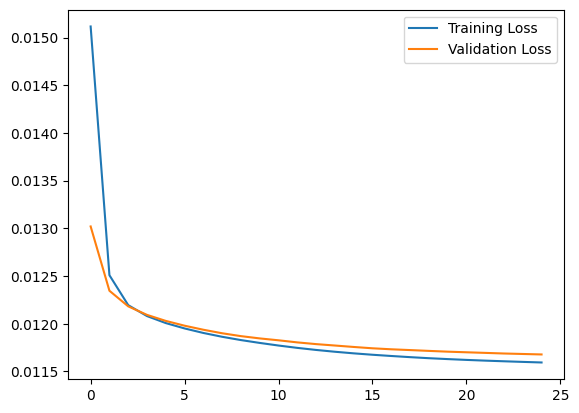

In [25]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

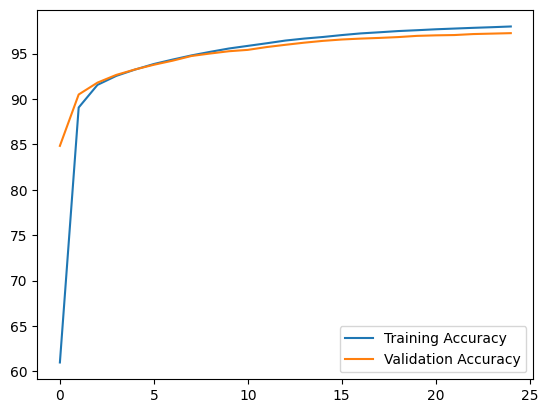

In [26]:
# Plot training and validation accuracy in the same plot

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()

In [27]:
torch.save(model.state_dict(), SAVE_STATE_PATH)

#### Loading Saved Model

In [28]:
model = ResNet()
model.load_state_dict(torch.load(SAVE_STATE_PATH))

<All keys matched successfully>